In [42]:
# Import libraries for:

# Web scraping
import requests 
from bs4 import BeautifulSoup

# Data analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import
from myfuncs import *

# A. Unsupervised Learning Phase

## A1. Data Extraction

### A1.1 State-level features from FRED

##### Income

In [2]:
# Data: Median household income by state (2022, 2023)
# Extraction: GET
url = 'https://fred.stlouisfed.org/release/tables?rid=249&eid=259462' # Median household income by state
variable = 'Median Household Income'
income_df = extract_FRED_data(url,variable)
income_df.head()

,State Name,Median Household Income [Current Dollars] (2023),Median Household Income [Current Dollars] (2022)
0,The United States,80610.0,74580.0
1,Alabama,60660.0,59910.0
2,Alaska,98190.0,89740.0
3,Arizona,82660.0,73450.0
4,Arkansas,63250.0,53980.0


##### Unemployment

In [3]:
url = 'https://fred.stlouisfed.org/release/tables?eid=840687&rid=116'
variable = 'Unemployment Rate'
UE_df = extract_FRED_data(url,variable)
UE_df.head()

,State Name,Unemployment Rate [Percent] (2023),Unemployment Rate [Percent] (2022)
0,Alabama,2.5,2.5
1,Alaska,4.2,4.2
2,Arizona,3.9,3.8
3,Arkansas,3.3,3.2
4,California,4.8,4.3


##### Population

In [4]:
url = 'https://fred.stlouisfed.org/release/tables?eid=259194&rid=118'
variable = 'Population'
pop_df = extract_FRED_data(url,variable)
pop_df.head()

,State Name,Population [Thousands of Persons] (2023),Population [Thousands of Persons] (2022)
0,Alabama,5108.468,5073.903
1,Alaska,733.406,733.276
2,Arizona,7431.344,7365.684
3,Arkansas,3067.732,3046.404
4,California,38965.193,39040.616


### A1.2 State-level Features from USCB (US Census Bureau)

In [5]:

variables_USCB = ['B19013_001E','B19301_001E','B23025_005E','B23025_003E','B19083_001E','B01003_001E','B01002_001E','B05002_013E','B25077_001E']

acs_2023_df = extract_ACS(api_key=apikey_USCB, year=2023, variables=variables_USCB, state_code=None)
acs_2022_df =  extract_ACS(api_key=apikey_USCB, year=2022, variables=variables_USCB, state_code=None)

# acs_2022_df.head()
# acs_2023_df.head()

In [6]:
new_acs_cols = [
    'Median Household Income ',
    'Per Capita Income',
    'Unemployed Population',
    'Employed Population',
    'Gini Index of Income Inequality',
    'Total Population',
    'Median Age',
    'Foreigner Population',
    'Median Home Value', 
    'State Code (FIPS)'
]

acs_2022_df.columns = new_acs_cols 
acs_2023_df.columns = new_acs_cols 

# acs_2022_df.head()
acs_2023_df.head()

,Median Household Income,Per Capita Income,Unemployed Population,Employed Population,Gini Index of Income Inequality,Total Population,Median Age,Foreigner Population,Median Home Value,State Code (FIPS)
0,62212,35046,96059,2394000,0.4771,5108468,39.6,203143,216600,01
1,86631,45792,17505,362965,0.4492,733406,36.5,54571,347500,02
2,77315,41290,155185,3648728,0.4650,7431344,39.3,980927,411200,04
3,58700,33012,59710,1435261,0.4740,3067732,38.9,162340,195700,05
4,95521,48013,1110856,20137422,0.4870,38965193,38.2,10640017,725800,06


In [7]:
num_cols = [col for col in acs_2022_df if 'State' not in col]
# num_cols
acs_2022_df[num_cols] = acs_2022_df[num_cols].astype(float)
acs_2023_df[num_cols] = acs_2023_df[num_cols].astype(float)

In [8]:
acs_2022_df['Unemployment Rate'] = acs_2022_df['Unemployed Population']/acs_2022_df['Total Population']
acs_2022_df['Percent Foreigners'] = acs_2022_df['Foreigner Population']/acs_2022_df['Total Population']
acs_2022_df.drop(columns=['Unemployed Population','Employed Population','Foreigner Population'], inplace=True)

acs_2023_df['Unemployment Rate'] = acs_2023_df['Unemployed Population']/acs_2023_df['Total Population']
acs_2023_df['Percent Foreigners'] = acs_2023_df['Foreigner Population']/acs_2023_df['Total Population']
acs_2023_df.drop(columns=['Unemployed Population','Employed Population','Foreigner Population'], inplace=True)

In [9]:
# Extract Mapper to transform State Code (FIPS) to State Name
FIPS_df = extract_FIPS()
FIPS_df.columns = ['State Name', 'State Code (FIPS)', 'State Code (USPS)']
FIPS_df.head()

,State Name,State Code (FIPS),State Code (USPS)
0,Alabama,01,AL
1,Alaska,02,AK
2,Arizona,04,AZ
3,Arkansas,05,AR
4,California,06,CA


In [10]:
acs_2022_df= pd.merge(acs_2022_df, FIPS_df, on = 'State Code (FIPS)', how = 'left').dropna() # NaN row is from FIPS code 72 -- Puerto Rico
acs_2023_df= pd.merge(acs_2023_df, FIPS_df, on = 'State Code (FIPS)', how = 'left').dropna()
acs_2022_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Unemployment Rate,Percent Foreigners,State Name,State Code (USPS)
0,59674.0,33777.0,0.4851,5074296.0,39.6,200900.0,01,0.020345,0.037687,Alabama,AL
1,88121.0,43054.0,0.4278,733583.0,35.9,336900.0,02,0.022471,0.075073,Alaska,AK
2,74568.0,39819.0,0.4665,7359197.0,38.8,402800.0,04,0.020918,0.130814,Arizona,AZ
3,55432.0,31380.0,0.4799,3045637.0,38.9,179800.0,05,0.020475,0.051245,Arkansas,AR
4,91551.0,46661.0,0.4953,39029342.0,37.9,715900.0,06,0.027180,0.267184,California,CA


In [11]:
# acs_2022_df.columns = [col+' (2022)' if 'State' not in col else col for col in acs_2022_df.columns]
# acs_2023_df.columns = [col+' (2023)' if 'State' not in col else col for col in acs_2023_df.columns] 
# acs_2022_df.head()

# acs_df = pd.merge(acs_2022_df, acs_2023_df, on = [col for col in acs_2022_df.columns if 'State' in col])
# acs_df.head()

In [12]:
acs_2022_df['Year'] = '2022'
acs_2023_df['Year'] = '2023'

In [13]:
acs_df = pd.concat([acs_2022_df, acs_2023_df],axis=0)
acs_df = acs_df.sort_index(axis=1)
acs_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,01,AL,Alabama,5074296.0,0.020345,2022
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,02,AK,Alaska,733583.0,0.022471,2022
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,04,AZ,Arizona,7359197.0,0.020918,2022
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,05,AR,Arkansas,3045637.0,0.020475,2022
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,06,CA,California,39029342.0,0.027180,2022


In [14]:
acs_df.tail()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year
46,0.4723,39.3,382900.0,89931.0,48689.0,0.133493,51,VA,Virginia,8715698.0,0.018889,2023
47,0.4703,38.6,576000.0,94605.0,52011.0,0.155376,53,WA,Washington,7812880.0,0.023344,2023
48,0.4679,42.8,163700.0,55948.0,32766.0,0.018263,54,WV,West Virginia,1770071.0,0.020255,2023
49,0.4479,40.5,272500.0,74631.0,41785.0,0.052090,55,WI,Wisconsin,5910955.0,0.014711,2023
50,0.4455,39.3,298700.0,72415.0,39966.0,0.036431,56,WY,Wyoming,584057.0,0.016303,2023


In [15]:
# ^Can build this whole section into a pipeline?

In [16]:
acs_df.to_csv('assets/acs_df.csv', index=None)

## A2. EDA

In [17]:
# USCB data alone looks sufficient; more overarching than FRED data. Let's try to work on it first

### SPLOMs

In [18]:
acs_df = pd.read_csv('assets/acs_df.csv')
acs_df.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,1,AL,Alabama,5074296.0,0.020345,2022
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,2,AK,Alaska,733583.0,0.022471,2022
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,4,AZ,Arizona,7359197.0,0.020918,2022
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,5,AR,Arkansas,3045637.0,0.020475,2022
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,6,CA,California,39029342.0,0.027180,2022


In [19]:
acs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Gini Index of Income Inequality  102 non-null    float64
 1   Median Age                       102 non-null    float64
 2   Median Home Value                102 non-null    float64
 3   Median Household Income          102 non-null    float64
 4   Per Capita Income                102 non-null    float64
 5   Percent Foreigners               102 non-null    float64
 6   State Code (FIPS)                102 non-null    int64  
 7   State Code (USPS)                102 non-null    object 
 8   State Name                       102 non-null    object 
 9   Total Population                 102 non-null    float64
 10  Unemployment Rate                102 non-null    float64
 11  Year                             102 non-null    int64  
dtypes: float64(8), int64(2

In [20]:
acs_df['State Code (FIPS)'] = acs_df['State Code (FIPS)'].astype(str)
acs_df['Year'] = acs_df['Year'].astype(str)
# len(acs_df) #51
num_cols = acs_df.select_dtypes([float,int]).columns.to_list()

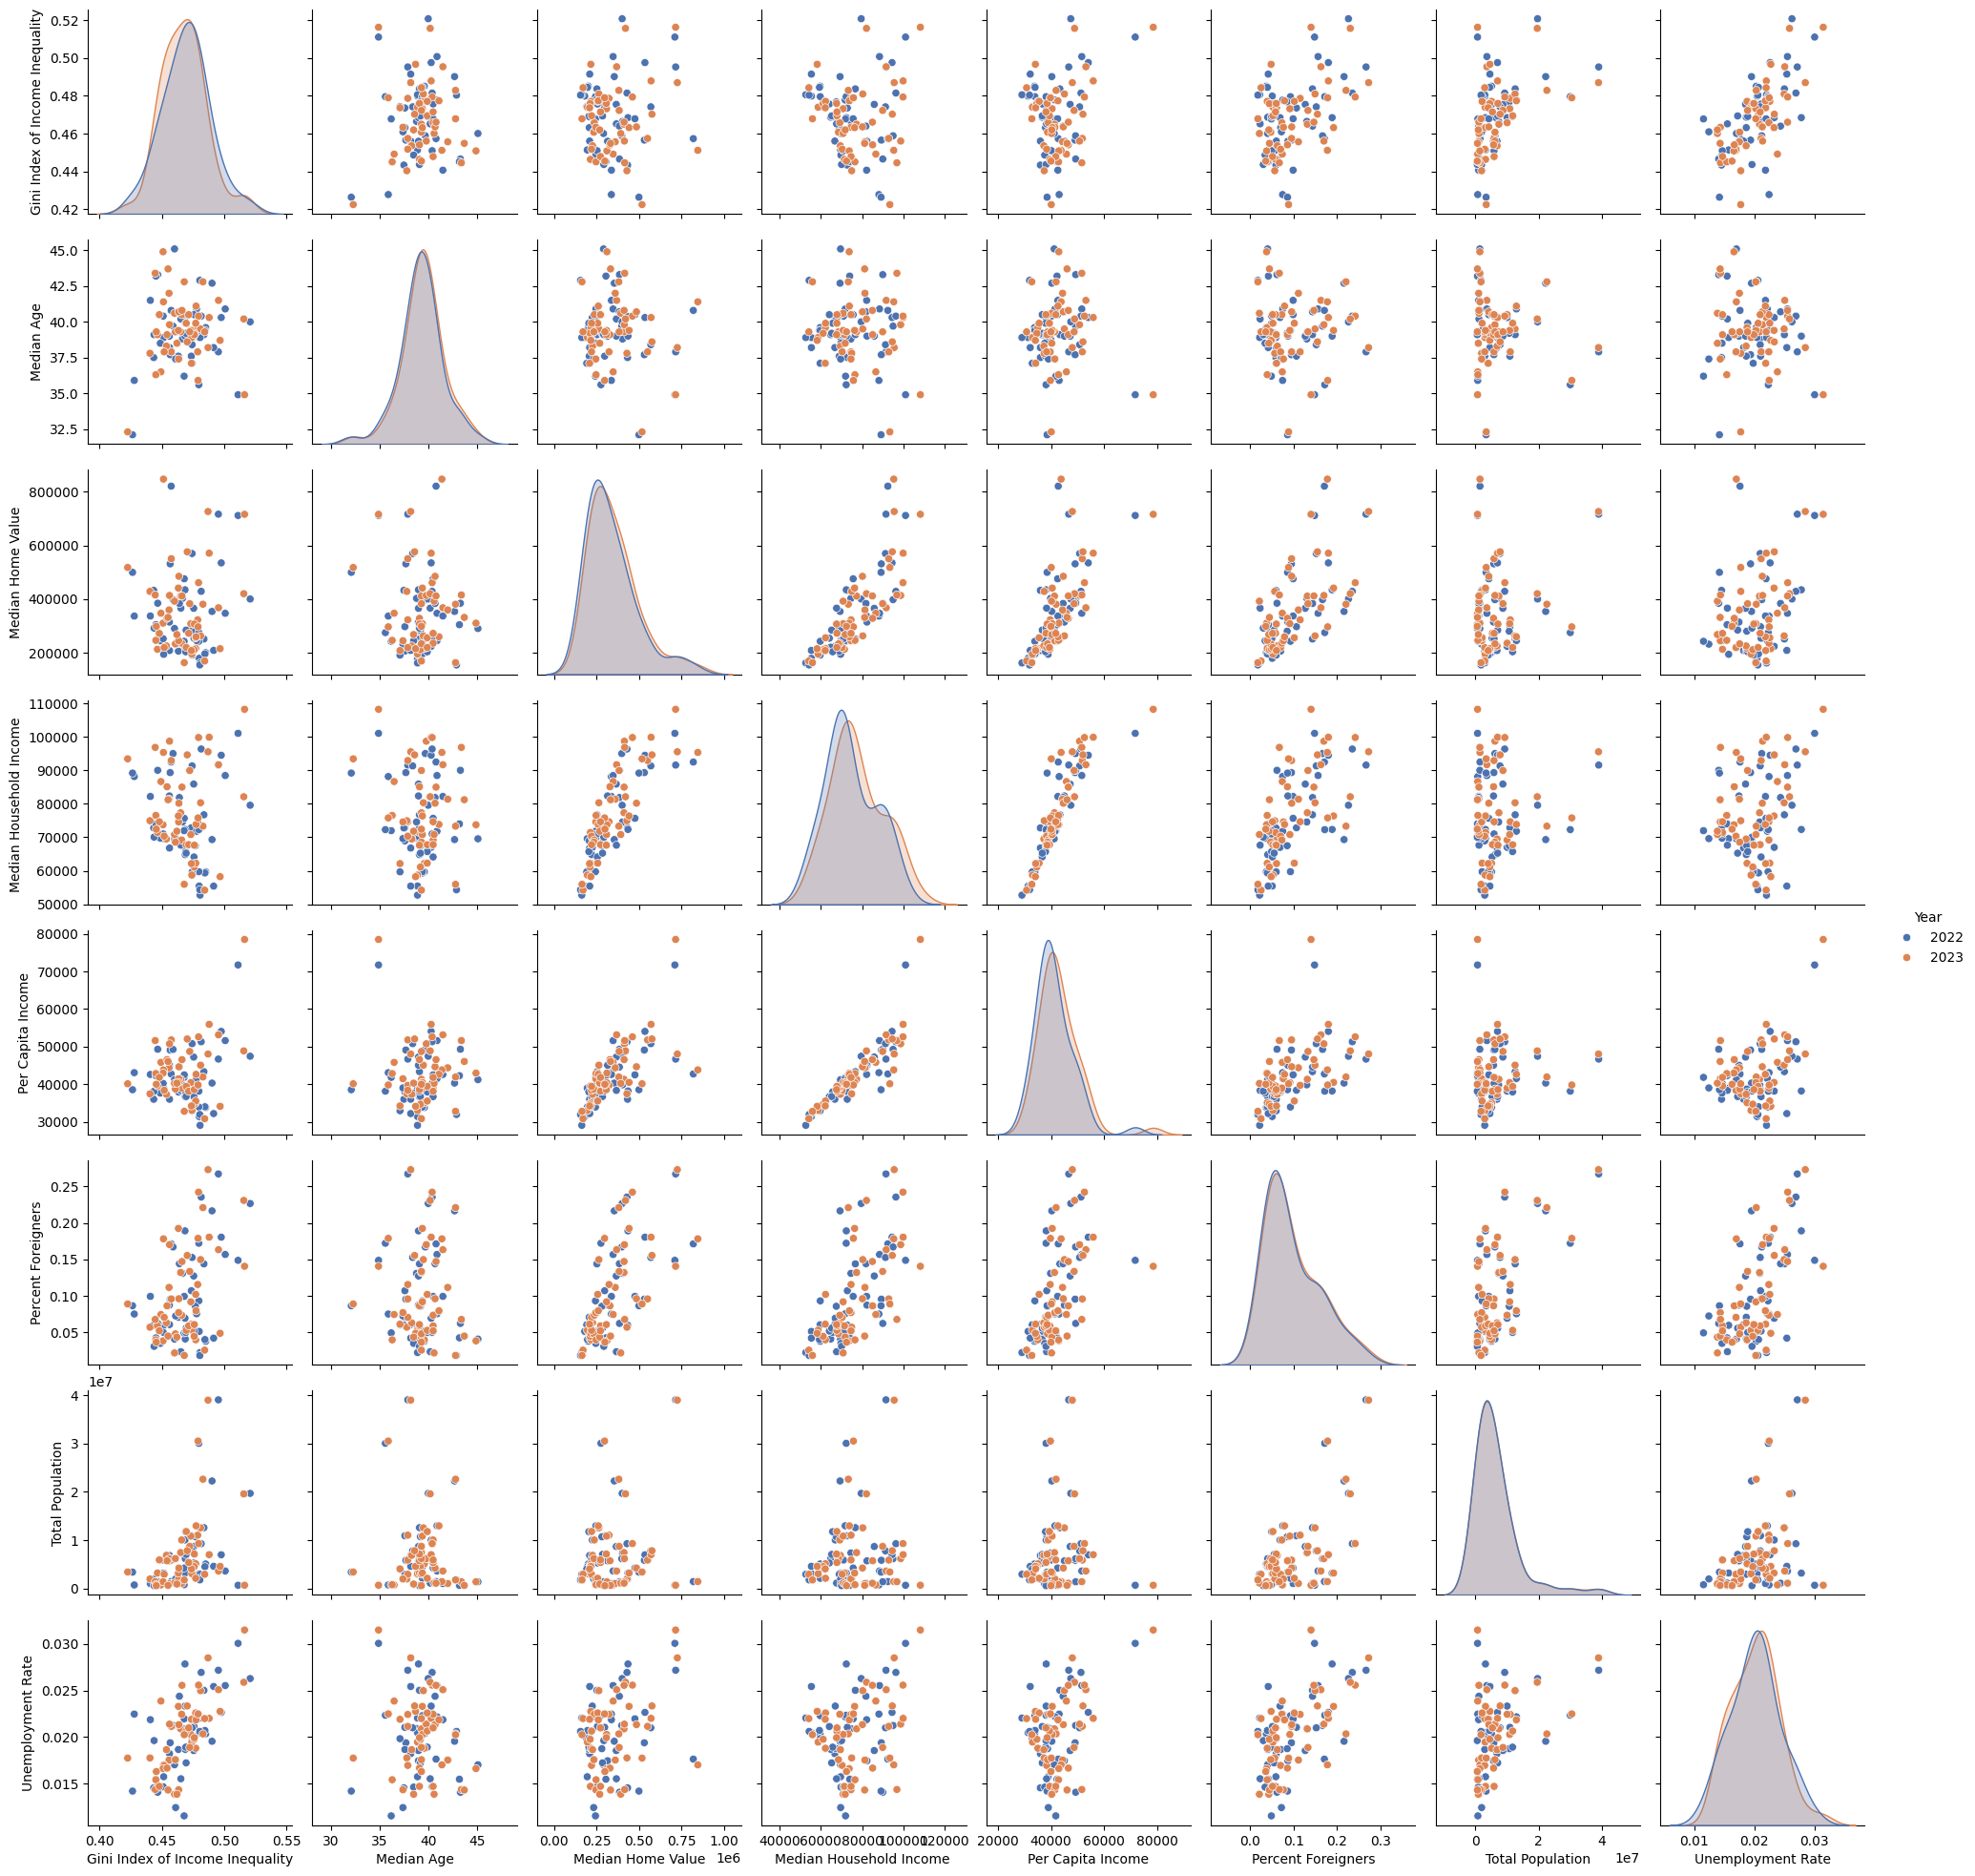

In [21]:
img_name = 'acs_SPLOMs'
tmp = acs_df[num_cols+['Year']].copy()

# custom_palette = {'2022': 'blue', '2023': 'red'}
sns.pairplot(tmp, hue="Year", palette='deep')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

# # Load saved SPLOM
# img = mpimg.imread(f'visualizations/{img_name}.png')
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [22]:
# Looks quite linear, can first explore PCA for Dimensionality Reduction
# Else, consider MDS/ Kernel PCA

### A2.1 Dimensionality Reduction

In [23]:
# Since both 2022 and 2023 data distributions appear to be similar for the various states, let's use both of the years' data for dimensionality reduction
# Alternatively, can consider filtering just one year data

#### PCA

In [24]:
# Normalize for PCA
scaler = StandardScaler()
acs_df_scaled = acs_df.copy()
acs_df_scaled[num_cols] = scaler.fit_transform(acs_df_scaled[num_cols])

pca = PCA()
pca.fit(acs_df_scaled[num_cols])
explainedVariance = pca.explained_variance_ratio_
explainedVariance_cum = np.cumsum(pca.explained_variance_ratio_)
explainedVariance_cum


array([0.45912709, 0.67828291, 0.80579373, 0.90219126, 0.94448653,
       0.97677417, 0.99672587, 1.        ])

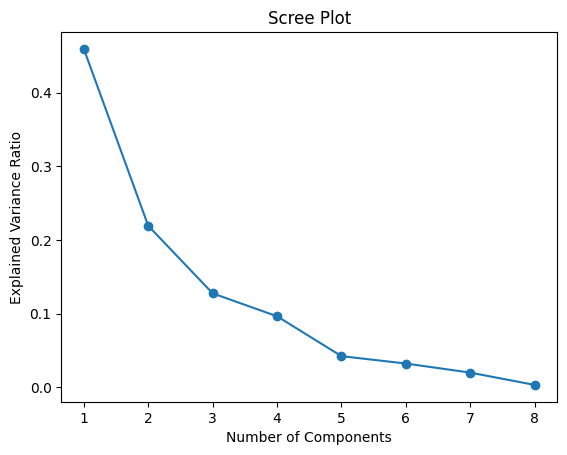

In [25]:
## Select n_components based on 95% of variance explained -> 6
# n_components = np.argmax(explainedVariance_cum >= 0.95) + 1 #np.argmax returns the index of the first occurence of max value ('1') - i.e. index of first element which satisfy the criteria >0.95
# n_components #np.int64(6)

## Alternatively, select n_components using Elbow method (Scree plot) -> 3
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show() # 3 components looks good


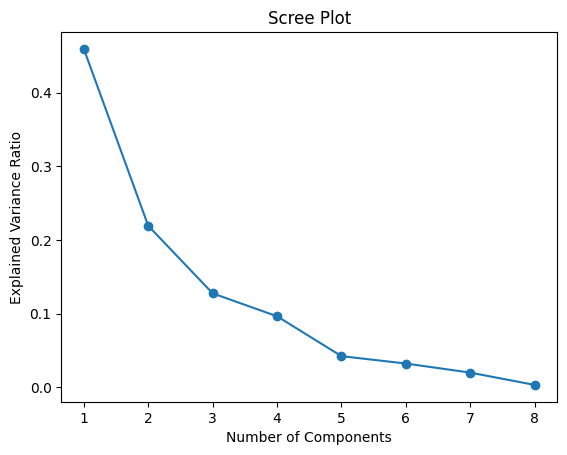

In [26]:
img_name = 'PCA_ExplainedVariance_CUM_ScreePlot'

plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show() # 3 components looks goodplt.plot(np.arange(1, len(explainedVariance_cum) + 1), explainedVariance_cum, marker='o')

In [27]:
# let's do PCA with 3 components
n=3
pca = PCA(n_components=n)
# pca.fit(acs_df_scaled[num_cols])
pca_result = pca.fit_transform(acs_df_scaled[num_cols])

# Explained Variance
explainedVariance_byComponent = pca.explained_variance_ratio_
# explainedVariance_byComponent
explainedVariance_total = np.cumsum(pca.explained_variance_ratio_)[-1]
# explainedVariance_total

# Component contributions
component_cont = pca.components_
# component_cont
pca_components_df = pd.DataFrame(pca.components_, columns=num_cols, index=[f'PC{i+1}' for i in range(n)])
pca_components_df 

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,Total Population,Unemployment Rate
PC1,0.252363,-0.059711,0.415227,0.419512,0.420373,0.465446,0.256893,0.353548
PC2,0.544120,0.070156,-0.316384,-0.421638,-0.289480,0.116371,0.427119,0.375983
PC3,0.143883,0.957226,-0.008247,0.026998,0.156012,0.015981,-0.191515,-0.030768


In [28]:
acs_df.columns = acs_df.columns.str.strip() # Remove trailing whitespace from column names like Median Household Income
acs_df.columns

Index(['Gini Index of Income Inequality', 'Median Age', 'Median Home Value',
       'Median Household Income', 'Per Capita Income', 'Percent Foreigners',
       'State Code (FIPS)', 'State Code (USPS)', 'State Name',
       'Total Population', 'Unemployment Rate', 'Year'],
      dtype='object')

In [55]:
pca_df 
# pca_result

,PC1,PC2,PC3
0,-1.682305,1.490303,0.064293
1,-0.192972,-1.907966,-1.647544
2,0.322067,0.106952,-0.323800
3,-2.028157,1.514902,-0.285048
4,5.262051,2.100556,-1.167033
...,...,...,...
97,1.229895,-0.628937,0.140417
98,2.639778,-1.003734,-0.118008
99,-2.560551,1.092746,1.383343
100,-1.427260,-1.001973,0.387884


In [29]:
# Convert the PCA results into a DataFrame
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n)])
# Concatenate the original data with PCA components
acs_with_pca = pd.concat([acs_df.reset_index(drop=True), pca_df], axis=1)
acs_with_pca.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year,PC1,PC2,PC3
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,1,AL,Alabama,5074296.0,0.020345,2022,-1.682305,1.490303,0.064293
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,2,AK,Alaska,733583.0,0.022471,2022,-0.192972,-1.907966,-1.647544
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,4,AZ,Arizona,7359197.0,0.020918,2022,0.322067,0.106952,-0.323800
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,5,AR,Arkansas,3045637.0,0.020475,2022,-2.028157,1.514902,-0.285048
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,6,CA,California,39029342.0,0.027180,2022,5.262051,2.100556,-1.167033


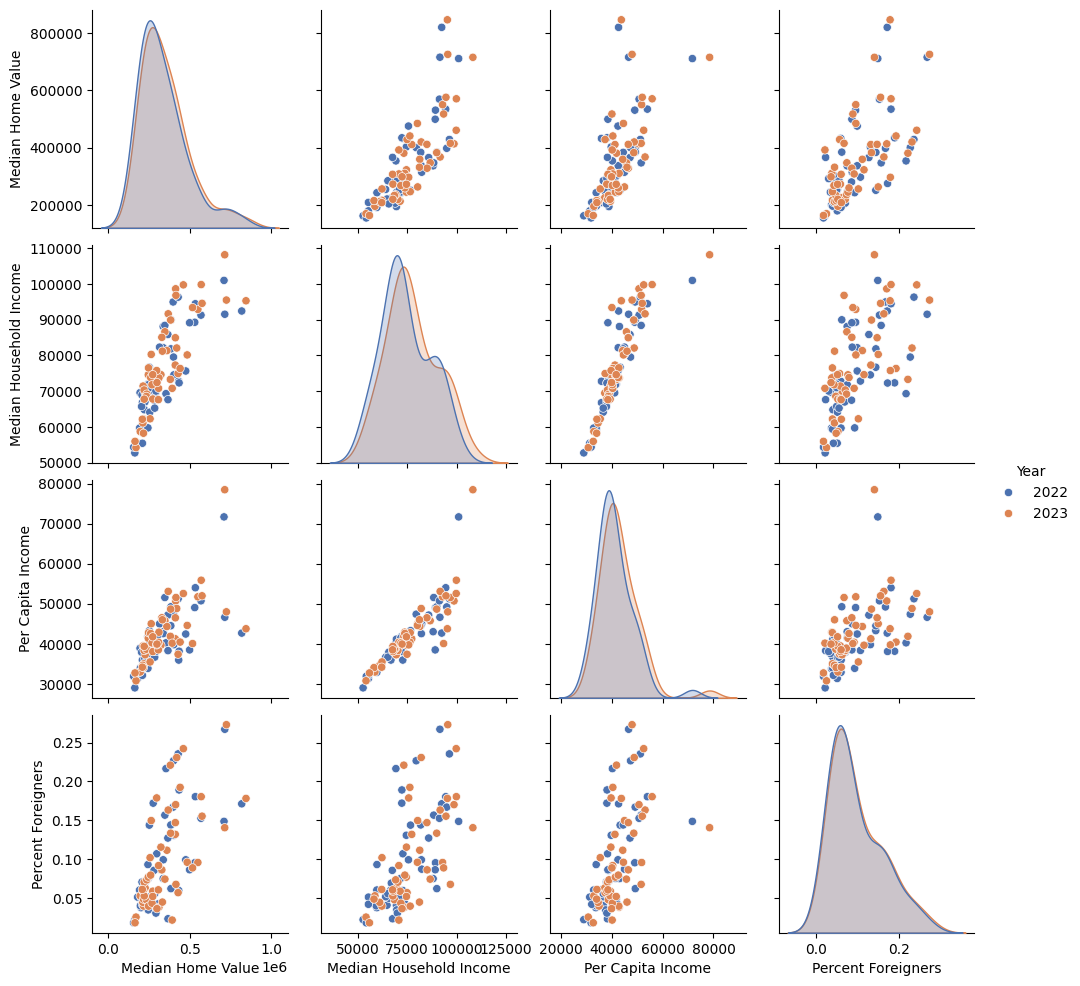

In [30]:
# Main features for PC1 -> (Indeed, these are correlated! - expected for PC1 to capture the main trends)
main_cols_pc1 = ['Median Home Value','Median Household Income', 'Per Capita Income', 'Percent Foreigners']
img_name_pc1 = 'acs_PC1_SPLOMs'
cols = main_cols_pc1
img_name = img_name_pc1

# # Main features for PC2 -> No strong correlations observed; Expected because it's capturing the remnants from PC1 (side trends)
# main_cols_pc2 = ['Gini Index of Income Inequality','Median Household Income', 'Total Population']
# img_name_pc2 = 'acs_PC2_SPLOMs'
# cols = main_cols_pc2
# img_name = img_name_pc2


tmp = acs_df[cols+['Year']].copy()
sns.pairplot(tmp, hue="Year", palette='deep')
# plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()


#### MDS

### A2.2 Clustering

In [31]:
# For Clustering, however, we want to use just one year's data , so as to avoid having multiple clusters per state
# Let's go with 2023 since it is the more updated one

#### K-Means
- assumes spherical clusters

In [32]:
# PCA + KMeans
acs_with_pca_2023 = acs_with_pca[acs_with_pca.Year == '2023']
pca_cols = [col for col in acs_with_pca_2023 if 'PC' in col]
acs_with_pca_2023[pca_cols].head()

,PC1,PC2,PC3
51,-1.711439,0.946261,0.044419
52,0.337264,-1.205051,-1.175728
53,0.494303,-0.085424,-0.082121
54,-1.939560,1.042558,-0.283277
55,5.536435,1.790967,-1.071618


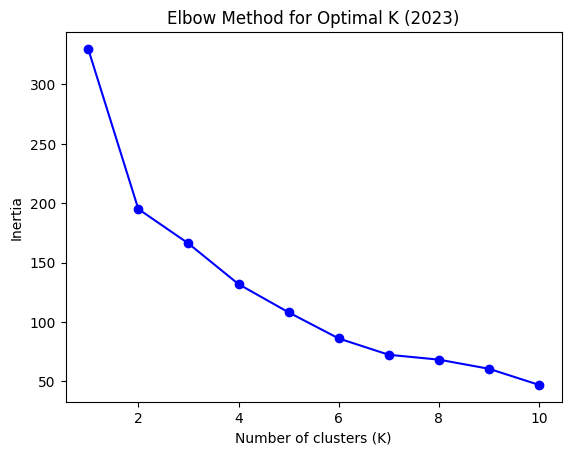

In [33]:
# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_with_pca_2023[pca_cols])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (2023)')
plt.show()
# either 3 or 4, can compare Silhoutte Scores

In [45]:
# Compare Silhouette Score for K=3 and K=4

# For K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(acs_with_pca_2023[pca_cols])
labels_3 = kmeans_3.labels_

# Compute silhouette score for K=3
silhouette_score_k3 = silhouette_score(acs_with_pca_2023[pca_cols], labels_3)
print(f'Silhouette Score for K=3: {silhouette_score_k3}')

# For K=4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(acs_with_pca_2023[pca_cols])
labels_4 = kmeans_4.labels_

# Compute silhouette score for K=4
silhouette_score_k4 = silhouette_score(acs_with_pca_2023[pca_cols], labels_4)
print(f'Silhouette Score for K=4: {silhouette_score_k4}')

# Silhouette Score for K=3: 0.24161208743828955
# Silhouette Score for K=4: 0.2862617751308079
# K=4 gives better clustering

Silhouette Score for K=3: 0.24161208743828955
Silhouette Score for K=4: 0.2862617751308079


In [46]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
acs_with_pca_and_kmeans_2023 = acs_with_pca_2023.copy()
acs_with_pca_and_kmeans_2023['Cluster'] = kmeans.fit_predict(acs_with_pca_and_kmeans_2023[pca_cols])
acs_with_pca_and_kmeans_2023.head()

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year,PC1,PC2,PC3,Cluster
51,0.4771,39.6,216600.0,62212.0,35046.0,0.039766,1,AL,Alabama,5108468.0,0.018804,2023,-1.711439,0.946261,0.044419,1
52,0.4492,36.5,347500.0,86631.0,45792.0,0.074408,2,AK,Alaska,733406.0,0.023868,2023,0.337264,-1.205051,-1.175728,2
53,0.4650,39.3,411200.0,77315.0,41290.0,0.131999,4,AZ,Arizona,7431344.0,0.020882,2023,0.494303,-0.085424,-0.082121,2
54,0.4740,38.9,195700.0,58700.0,33012.0,0.052919,5,AR,Arkansas,3067732.0,0.019464,2023,-1.939560,1.042558,-0.283277,1
55,0.4870,38.2,725800.0,95521.0,48013.0,0.273065,6,CA,California,38965193.0,0.028509,2023,5.536435,1.790967,-1.071618,3


In [47]:
state_cols = [col for col in acs_with_pca_and_kmeans_2023 if 'State' in col]
state_cluster_df = acs_with_pca_and_kmeans_2023[state_cols+['Cluster']]
state_cluster_df.head() #based on 2023 data!

# Merge cluster data back to the original data (for both 2022 and 2023)
acs_with_pca_and_kmeans = acs_with_pca.copy()
acs_with_pca_and_kmeans = pd.merge(acs_with_pca_and_kmeans, state_cluster_df, on=state_cols, how='left')
acs_with_pca_and_kmeans.head()

# acs_with_pca_and_kmeans.to_csv('assets/acs_with_pca_and_kmeans.csv', index=None)

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year,PC1,PC2,PC3,Cluster
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,1,AL,Alabama,5074296.0,0.020345,2022,-1.682305,1.490303,0.064293,1
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,2,AK,Alaska,733583.0,0.022471,2022,-0.192972,-1.907966,-1.647544,2
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,4,AZ,Arizona,7359197.0,0.020918,2022,0.322067,0.106952,-0.323800,2
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,5,AR,Arkansas,3045637.0,0.020475,2022,-2.028157,1.514902,-0.285048,1
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,6,CA,California,39029342.0,0.027180,2022,5.262051,2.100556,-1.167033,3


#### DBSCAN
- does not assume spherical clusters

In [67]:
# Let's try to optimize DBSCAN first

X_pca= acs_with_pca_2023[pca_cols]
# Try different values of eps and min_samples
eps_values = [0.3, 0.5, 0.7]  # Test a range of eps values
min_samples_values = [5, 10, 15]  # Test different min_samples values

# Loop over the eps and min_samples values to find the best combination
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)  # Assuming X_pca is your PCA-reduced data
        
        # Plot the results
        plt.figure(figsize=(5, 4))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
        plt.title(f'DBSCAN with eps={eps} and min_samples={min_samples}')
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.figure(figsize=(3,2))
        plt.show()
        #All don't look too good..


InvalidIndexError: (slice(None, None, None), 0)

<Figure size 500x400 with 0 Axes>

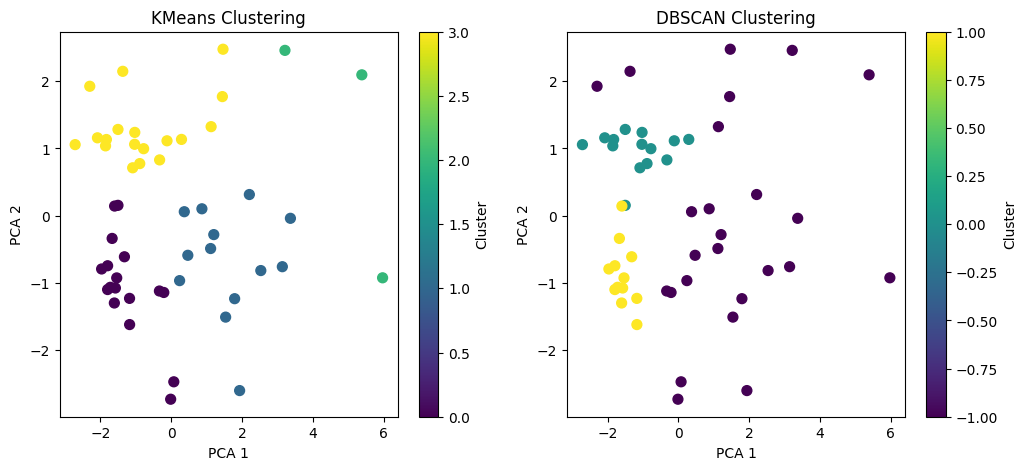

In [60]:
# Is DBSCAN better than KMeans? --> No

# Generate synthetic data (for example)
# X, _ = make_blobs(n_samples=500, centers=4, cluster_std=1.0, random_state=42)
X= acs_with_pca_2023[pca_cols]

# Optionally, reduce dimensions using PCA (if working with high-dimensional data)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# DBSCAN clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Plot KMeans clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.colorbar(label="Cluster")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Plot DBSCAN clusters
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering')
plt.colorbar(label="Cluster")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()


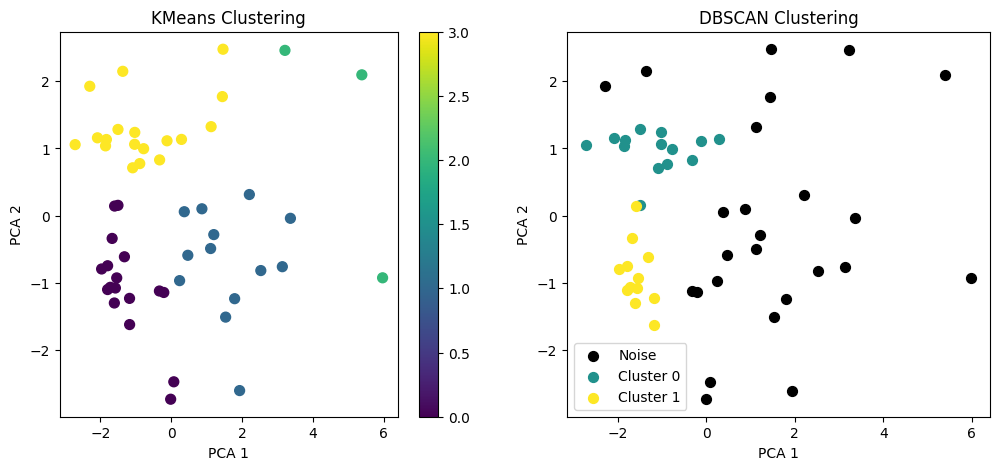

In [61]:

# Assume X is already defined as acs_with_pca_2023[pca_cols]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Plot KMeans clusters
plt.figure(figsize=(12, 5))

# KMeans Plot
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering')
plt.colorbar()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# DBSCAN Plot
plt.subplot(1, 2, 2)

# Define color for noise points (label -1)
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Plot noise as black ('k')
        plt.scatter(X_pca[dbscan_labels == label, 0], X_pca[dbscan_labels == label, 1], c='k', s=50, label='Noise')
    else:
        # Plot clusters with color map
        plt.scatter(X_pca[dbscan_labels == label, 0], X_pca[dbscan_labels == label, 1], c=[color], s=50, label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

plt.show()


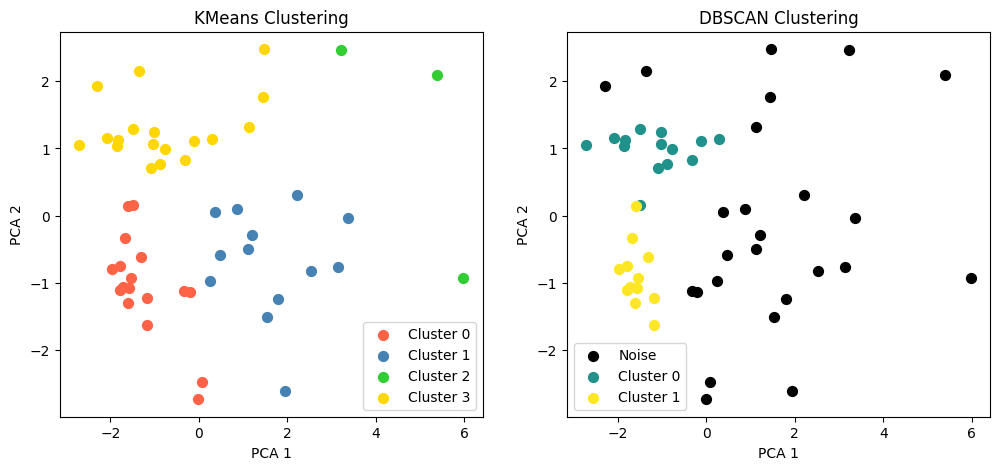

In [62]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import numpy as np

# Assume X is already defined as acs_with_pca_2023[pca_cols]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Custom colors for clusters (categorical colors, not continuous)
cluster_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']  # You can expand this list for more clusters

# Plot KMeans clusters
plt.figure(figsize=(12, 5))

# KMeans Plot
plt.subplot(1, 2, 1)
for i, color in enumerate(cluster_colors):
    plt.scatter(X_pca[kmeans_labels == i, 0], X_pca[kmeans_labels == i, 1], 
                c=color, label=f'Cluster {i}', s=50)
plt.title('KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

# DBSCAN Plot
plt.subplot(1, 2, 2)

# Define color for noise points (label -1)
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Plot noise as black ('k')
        plt.scatter(X_pca[dbscan_labels == label, 0], X_pca[dbscan_labels == label, 1], 
                    c='k', s=50, label='Noise')
    else:
        # Plot clusters with categorical color map
        plt.scatter(X_pca[dbscan_labels == label, 0], X_pca[dbscan_labels == label, 1], 
                    c=[color], s=50, label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

plt.show()


In [50]:
pca_components_df

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,Total Population,Unemployment Rate
PC1,0.252363,-0.059711,0.415227,0.419512,0.420373,0.465446,0.256893,0.353548
PC2,0.544120,0.070156,-0.316384,-0.421638,-0.289480,0.116371,0.427119,0.375983
PC3,0.143883,0.957226,-0.008247,0.026998,0.156012,0.015981,-0.191515,-0.030768


In [63]:
# acs_with_pca_and_kmeans 
acs_final = pd.read_csv('assets/acs_with_pca_and_kmeans.csv')
acs_final

,Gini Index of Income Inequality,Median Age,Median Home Value,Median Household Income,Per Capita Income,Percent Foreigners,State Code (FIPS),State Code (USPS),State Name,Total Population,Unemployment Rate,Year,PC1,PC2,PC3,Cluster
0,0.4851,39.6,200900.0,59674.0,33777.0,0.037687,1,AL,Alabama,5074296.0,0.020345,2022,-1.682305,1.490303,0.064293,1
1,0.4278,35.9,336900.0,88121.0,43054.0,0.075073,2,AK,Alaska,733583.0,0.022471,2022,-0.192972,-1.907966,-1.647544,2
2,0.4665,38.8,402800.0,74568.0,39819.0,0.130814,4,AZ,Arizona,7359197.0,0.020918,2022,0.322067,0.106952,-0.323800,2
3,0.4799,38.9,179800.0,55432.0,31380.0,0.051245,5,AR,Arkansas,3045637.0,0.020475,2022,-2.028157,1.514902,-0.285048,1
4,0.4953,37.9,715900.0,91551.0,46661.0,0.267184,6,CA,California,39029342.0,0.027180,2022,5.262051,2.100556,-1.167033,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.4723,39.3,382900.0,89931.0,48689.0,0.133493,51,VA,Virginia,8715698.0,0.018889,2023,1.229895,-0.628937,0.140417,2
98,0.4703,38.6,576000.0,94605.0,52011.0,0.155376,53,WA,Washington,7812880.0,0.023344,2023,2.639778,-1.003734,-0.118008,2
99,0.4679,42.8,163700.0,55948.0,32766.0,0.018263,54,WV,West Virginia,1770071.0,0.020255,2023,-2.560551,1.092746,1.383343,1
100,0.4479,40.5,272500.0,74631.0,41785.0,0.052090,55,WI,Wisconsin,5910955.0,0.014711,2023,-1.427260,-1.001973,0.387884,0


<Figure size 1200x800 with 0 Axes>

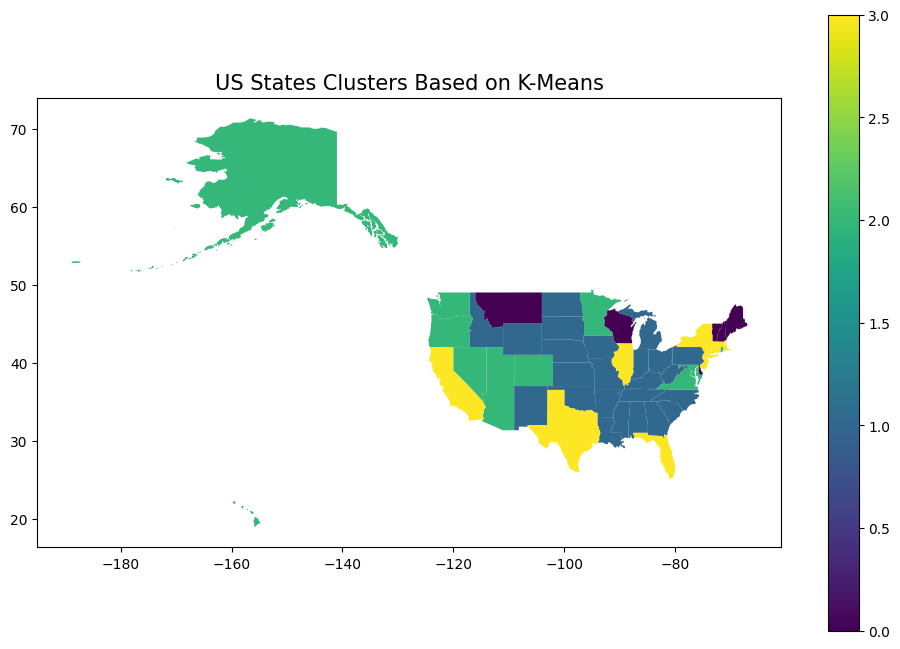

In [65]:
import geopandas as gpd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Load the shapefile for US states (can be done using geopandas)
# Here, we assume you have a US states shapefile available
# Use Geopandas to load a shapefile of the US
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
gdf = gpd.read_file(url)

# Step 2: Prepare your data
# Example data (replace this with your KMeans labels and state mapping)
# Assuming `acs_with_pca_2023` contains state data and corresponding KMeans cluster labels
# state_cluster_data = {
#     'Alabama': 0, 'Alaska': 1, 'Arizona': 2, 'Arkansas': 0, 'California': 2,
#     # Add other states here...
# }
state_cluster_data = dict(zip(acs_final['State Name'], acs_final['Cluster']))

# # Convert the dictionary to a DataFrame and merge with the GeoDataFrame
# import pandas as pd
# state_cluster_df = pd.DataFrame(list(state_cluster_data.items()), columns=['name', 'cluster'])

# # Step 3: Merge the clustering data with the GeoDataFrame for plotting
# gdf = gdf.merge(state_cluster_df, how='left', left_on='name', right_on='name')

# # Step 4: Plot the map
# plt.figure(figsize=(12, 8))
# gdf.boundary.plot()
# gdf.plot(column='cluster', cmap='viridis', legend=True, figsize=(12, 8))

# plt.title('US States Clusters Based on K-Means', fontsize=15)
# plt.show()


# Convert the dictionary to a DataFrame and merge with the GeoDataFrame
state_cluster_df = pd.DataFrame(list(state_cluster_data.items()), columns=['name', 'cluster'])

# Step 3: Merge the clustering data with the GeoDataFrame
gdf = gdf.merge(state_cluster_df, how='left', left_on='name', right_on='name')

# Step 4: Plot the map and color the states by clusters
plt.figure(figsize=(12, 8))
gdf.plot(column='cluster', cmap='viridis', legend=True, figsize=(12, 8))

plt.title('US States Clusters Based on K-Means', fontsize=15)
plt.show()

# B. Data Extraction for Supervised Learning Phase

## B1. T100 Domestic flight by origin airports (2023)
**Pros and Cons**: 
- Pro: Contains information on the actual number of departing passengers (passenger volume) from various origin airports, not just flight volume, unlike BTS data.
- Con: Only available for the year 2023, while BTS data contain flight volume for all years and thus is more comprehensive.

**Objective**:
- To show correlation between the volumes of passenger and flight, to justify the use BTS data for the analysis of air travel volume.

In [38]:
# 4. Mapper for US State Code to State Name

In [39]:
# 1. Domestic flight by origin airports (2023)
# Data: Flight volume by Airport Code; this will be our main dataset
# Extraction: csv download from https://equity-data.dot.gov/datasets/17e9a793c7cf47c8b64dab92da55dfe5/about
fp_flights = '../assets/T100_Domestic_Market_and_Segment_Data_-3591723781169319541.csv'
df_flights = pd.read_csv(fp_flights)
df_flights.columns = df_flights.columns.str.title()
df_flights.rename(columns={'Origin': 'Airport Code'}, inplace=True)
df_flights.head() #here, origin airport names ('origin') are abbreviated by the respective Airport Codes.

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334


In [40]:
# 1+. EDA
# df_flights[df_flights.isna().any(axis=1)] # Mainly NA for Arrivals column

numeric_cols = ['Enplanements', 'Passengers', 'Departures', 'Arrivals', 'Freight', 'Mail']
df_flights_cleaned = df_flights[numeric_cols].dropna()

# df_flights_cleaned_sample = df_flights_cleaned.sample(100)
# sns.pairplot(df_flights_cleaned_sample[numeric_cols]) #looks to have outliers (extreme high end), let's use StandardScaler

df_flights_cleaned_normalized = df_flights_cleaned.copy()
scaler = StandardScaler()
df_flights_cleaned_normalized[numeric_cols] = scaler.fit_transform(df_flights_cleaned_normalized[numeric_cols])
df_flights_cleaned_normalized_sample = df_flights_cleaned_normalized.sample(100)

# Define temporary df for plotting
# tmp = df_flights_cleaned_normalized_sample.copy()
tmp = df_flights_cleaned_normalized.copy()

# Replot SPLOM
# sns.pairplot(tmp[numeric_cols]) 
# plt.savefig('visualizations/flights_sampled100_normalized_SPLOMs.png', dpi=300)
# plt.show()

# See the relationship between number of departing passengers vs. departed flights 
# tmp.plot(x='Departures',y='Enplanements', kind='scatter')
# plt.savefig('visualizations/flights_normalized_Enplanements_vs_Depatures.png', dpi=300)

# Load saved SPLOM
# img_name = 'flights_sampled100_normalized_SPLOMs'
img_name = 'flights_normalized_Enplanements_vs_Depatures'
img = mpimg.imread(f'visualizations/{img_name}.png')
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [41]:
# 3. Mapper for airport code to airport name
# Data: Mapper for Airport Code, Airport Name, City, State (by State Code)
# Extraction: get from https://www.transtats.bts.gov/ONTIME/AirportInfo.html
url = 'https://www.transtats.bts.gov/ONTIME/AirportInfo.html'
response = requests.get(url)
assert response.status_code == 200
soup = BeautifulSoup(response.text, 'lxml')
# soup = BeautifulSoup(response.content, 'html.parser')
# print(soup.prettify())

table = soup.find('table')
rows = table.find_all('tr')

# Extract table data into a df
header_row = rows[0]
headers = [th.get_text(strip=True) for th in header_row.find_all('th')]
df_airports = pd.DataFrame(columns=headers)
for row in rows[1:]: #skip header row
    row_data = [td.get_text(strip=True) for td in row.find_all('td')]
    newrow_idx = len(df_airports) # newrow_idx = [lastrow_idx] +1 = [len(df)-1] +1 = len(df)
    df_airports.loc[newrow_idx] = row_data
# df_airports
col_name = 'Airport/City/State Name'
# df_airports[col_name] = df_airports['Airport/City/State Name'].str.strip().str.rstrip(',') #doesn't work, still have additional column of "None" values -> use n=2 instead
new_cols = col_name.split('/') # Expand Airport/City/State Name into three separate columns
df_airports[new_cols] = df_airports[df_airports.columns[1]].str.split(',', n=2, expand=True) #splits the string only at the first two commas
df_airports.drop(columns=[col_name],inplace=True)
df_airports.rename(columns={
    'State Name':'State Code',
    'Airport': 'Airport Name'
    }, 
    inplace=True
)
df_airports

,Airport Code,Airport Name,City,State Code
0,ABE,Lehigh Valley International,Allentown,PA
1,ABI,Abilene Regional,Abilene,TX
2,ABQ,Albuquerque International,Albuquerque,NM
3,ACK,Nantucket Memorial,Nantucket,MA
4,ADQ,Kodiak,Kodiak,AK
...,...,...,...,...
220,TWF,Joslin Field-Magic Valley Regional,Twin Falls,ID
221,TYS,McGhee Tyson,Knoxville,TN
222,VPS,Eglin Air Force Base,Valparaiso,FL
223,WRG,Wrangell,Wrangell,AK


## B2. BTS Data